# Assignment 5

EE2703: Applied Programming 
Author: Varun Sundar, EE16B068

Conventions
1. We are using Python 3, GCC for C 
2. Underscore naming vs Camel Case 
3. PEP 25 convention style.

# Abstract

This weeks assignment concerns with solving for a laplace equation (or poissons), using numerical approximations over a discrete grid.

# Introduction

Consider the given problem, where a wire is soldered to the middle of a copper plate and its voltage is held at 1 Volt. One side of the plate is grounded, while the remaining are floating. The plate is 1 cm by 1 cm in size.

Using the continuity of charge,

$${\nabla}\cdot{\vec{j}}=− \frac{\partial ρ}{\partial t}$$

and conductivity (or Maxwell's first equation alternatively),

$$\vec{j} = \sigma\vec{E}$$

Giving, (for uniform conductance)

$$ {\nabla}^{2}\phi =\frac{\partial p}{{\sigma}{\partial t} }$$

Which for DC currents gives the laplace equation.

$$ {\nabla}^{2}\phi =0$$

In [252]:
import mpl_toolkits.mplot3d.axes3d as p3
import numpy as np
from matplotlib import pyplot as plt

# Assignment Submissions

## Defining dimensions

We have chosen a grid of $25*25$ to start with. The radius of the wire is 0.35 cm, and we iterate for 1500 steps.

Variable *phi* represents the voltage at a given point. We begin by visualising the inital conditions of phi with a contour plot. 

In [171]:
Nx=25; # size along x
Ny=25; #size along y
radius=0.35;#radius of central lead
Niter=1500; #number of iterations to perform

In [172]:
phi=np.zeros((Nx,Ny))

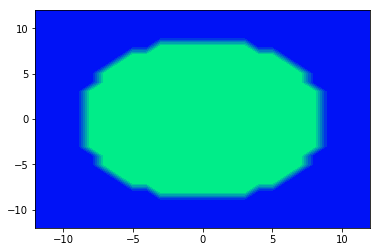

In [173]:
def initiate():
    global phi
    global X,Y
    phi=np.zeros((Nx,Ny))
    x,y=np.linspace(-12,12,num=25,dtype=int),np.linspace(-12,12,num=25,dtype=int)
    Y,X=np.meshgrid(y,x,sparse=False)
    phi[np.where(X**2+Y**2<(0.35*25)**2)]=1.0
initiate()
plt.contourf(X,Y,phi,cmap = plt.cm.get_cmap("winter"))

The iterative process comprises of :
    
$$ {\nabla}^{2}\phi =0 $$
~
$$(\phi[i,j+1]-\phi[i,j])+(\phi[i+1,j]-\phi[i,j])+(\phi[i-1,j]-\phi[i,j])+(\phi[i,j-1]-\phi[i,j])=0$$

or,

$$\phi[i,j]=(\phi[i+1,j]+\phi[i-1,j]+\phi[i,j-1]+\phi[i,j+1])/4$$

With ofcourse, appropriate boundary conditions fitted.

This isn't the most efficient methd for computing a solution to the laplace equation owing to its slow rate of error reduction.


In [174]:
def update_phi(oldphi):
    global phi
    phi[1:-1,1:-1]=0.25*(oldphi[1:-1,0:-2]+ oldphi[1:-1,2:]+ oldphi[0:-2,1:-1] + oldphi[2:,1:-1])

In [175]:
def assert_boundaries():
    global phi
    phi[1:-1,0]=phi[1:-1,1] # Left Boundary
    phi[1:-1,Nx-1]=phi[1:-1,Nx-2] # Right Boundary
    phi[0,1:-1]=phi[1,1:-1] # Top Boundary
    phi[Ny-1,1:-1]=0
    phi[np.where(X**2+Y**2<(0.35*25)**2)]=1.0

In [255]:
errors=np.zeros(Niter)
initiate()
for k in range(Niter):
    oldphi=phi.copy()
    update_phi(oldphi)
    assert_boundaries()
    errors[k]=(abs(phi-oldphi)).max();
    #plt.contourf(X,Y,phi,cmap = plt.cm.get_cmap("winter"))
print(errors)

[  5.00000000e-01   2.50000000e-01   1.09375000e-01 ...,   5.14033260e-14
   5.04041253e-14   4.94049246e-14]


We plot the errors found on a semi-logarithmic and logarithmic plot(s).

/Users/Ankivarun/anaconda3/envs/tf_python3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


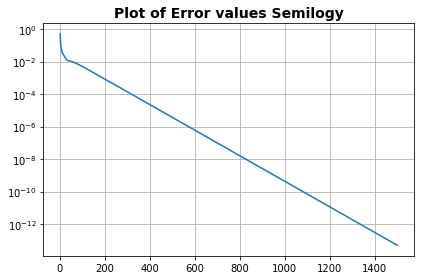

In [177]:
%matplotlib inline
figure, axarr= plt.subplots(1)

figure.figsize=(10,10)
axarr.grid(True)
axarr.set_title(r'Plot of Error values Semilogy', fontsize=14,fontweight="bold")
axarr.semilogy(np.arange(len(errors))+1,errors)

figure.tight_layout()
figure.show()

/Users/Ankivarun/anaconda3/envs/tf_python3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


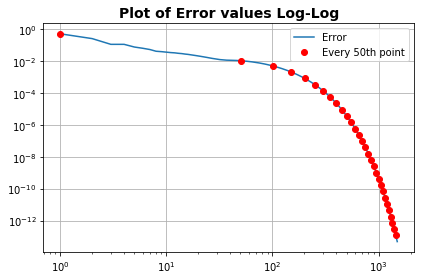

In [178]:
figure, axarr= plt.subplots(1)
figure.figsize=(10,10)
axarr.grid(True)
axarr.set_title(r'Plot of Error values Log-Log', fontsize=14,fontweight="bold")
axarr.loglog(np.arange(len(errors))+1,errors)
axarr.loglog((np.arange(len(errors))+1)[::50],errors[::50],'ro')
axarr.legend(('Error','Every 50th point'))
figure.tight_layout()
figure.show()

Noticing that the errors follow an exponential curve for *Niter*>100, we fit the points > 500 iterations with an exponential curve.

As a comparison, we do it for a fit of all points as well.

In [179]:
def fit_error(x,y):
    # x is the data vector, y are truth points
    log_y=np.log(y)
    x_vec=np.zeros((len(x),2))
    x_vec[:,0]=x
    x_vec[:,1]=1
    B,log_A=np.linalg.lstsq(x_vec, log_y.T)[0]
    return (np.exp(log_A),B)

def sanity_test(A,B,x,y):
    print (A*np.exp(B*x)[100:])
    print(y[100:])
    
A,B=fit_error(np.arange(Niter)+1,errors)
sanity_test(A,B,np.arange(Niter)+1,errors)

[  4.99157469e-03   4.90198207e-03   4.81399753e-03 ...,   5.12433373e-14
   5.03235825e-14   4.94203361e-14]
[  4.86880548e-03   4.78572424e-03   4.70372018e-03 ...,   5.14033260e-14
   5.04041253e-14   4.94049246e-14]


In [180]:
# Fit for all iterations
A_1,B_1=fit_error(np.arange(Niter)+1,errors)
# Fit after 500th iteration
A_2,B_2=fit_error((np.arange(Niter)+1)[500:],errors[500:])
print(A_1,B_1)
print(A_2,B_2)

0.0310948869373 -0.0181118016747
0.0311122771835 -0.0181118095507


/Users/Ankivarun/anaconda3/envs/tf_python3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


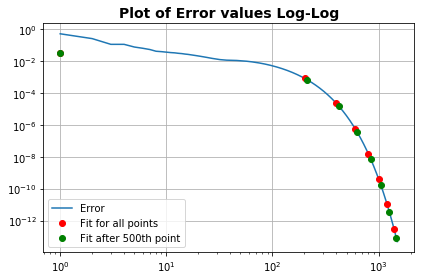

In [181]:
figure, axarr= plt.subplots(1)
figure.figsize=(20,20)
axarr.grid(True)
axarr.set_title(r'Plot of Error values Log-Log', fontsize=14,fontweight="bold")

num=np.arange(len(errors))+1
axarr.loglog(num,errors)
axarr.loglog(num[::200],A_1*np.exp(B_1*num)[::200],'ro')
axarr.loglog(num[::210],A_2*np.exp(B_2*num)[::210],'go')

axarr.legend(('Error','Fit for all points','Fit after 500th point'))
figure.tight_layout()
figure.show()

We notice that while the later is a better fit to the curve (exponential approximation after 500 iterations), the difference is hardly visible.

## Finding a maximum error metric

We notice that the maximum error scales as $error = A\exp{Bk}$.

Now,

$$Error = \sum_{k=N+1}^{\infty} error_k $$
$$< \sum_{k=N+1}^{\infty} A\exp{Bk} $$
$$ ≈ \int_{N +0.5}^{\infty}Aexp(Bk) dk $$

$$ = −A \exp{(B(N +0.5))}$$

This can hence, be used as an upper bound on the error. We plot this for the different number of iterations. Notice the slow reduction of the error. As mentioned earlier, this is one of the reasons that this approach to solving laplace's equation is dissuaded.

In [254]:
def find_terminal_error(A,B,Niter):
    return -A/B*np.exp(B*(Niter+0.5))

/Users/Ankivarun/anaconda3/envs/tf_python3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


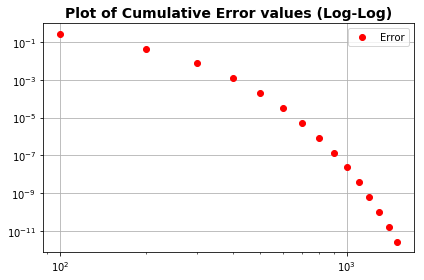

In [183]:
iterations=np.arange(100,1501,100)

figure, axarr= plt.subplots(1)
figure.figsize=(20,20)
axarr.grid(True)
axarr.set_title(r'Plot of Cumulative Error values (Log-Log)', fontsize=14,fontweight="bold")

axarr.loglog(iterations,find_terminal_error(A_2,B_2,iterations),'ro')

axarr.legend(('Error','Fit for all points','Fit after 500th point'))
figure.tight_layout()
figure.show()

## Plotting $\phi$

We plot 3-D surface plots, contour plots of $\phi$. In additon to, this the current denisities may be calculated as follows:

$$ J_{x}(i,j) = \frac{\phi(i,j−1) −\phi(i,j+1)}{2} $$
$$ J_{y}(i,j) = \frac{\phi(i-1,j) −\phi(i+1,j)}{2} $$

This is defined for all "interior" i,j- where finite difference can be used to approximate differentiation. The function *compute_J* does the above.

This is plotted as a quiver plot. Electrode points are marked by red dots.

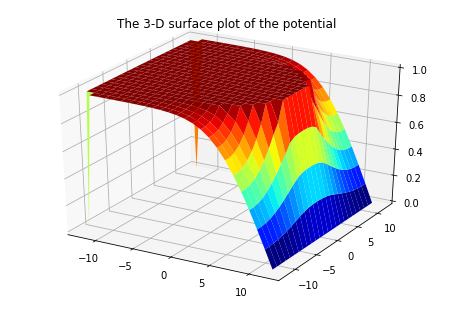

In [184]:
fig1=plt.figure(4)     # open a new figure
ax=p3.Axes3D(fig1) # Axes3D is the means to do a surface plot
plt.title('The 3-D surface plot of the potential')
surf = ax.plot_surface(Y, X, phi.T, rstride=1, cstride=1, cmap=plt.cm.jet)

In [185]:
def compute_J(phi):
    return (1/2*(phi[1:-1,0:-2]-phi[1:-1,2:]),1/2*(phi[:-2,1:-1]-phi[2:,1:-1]))

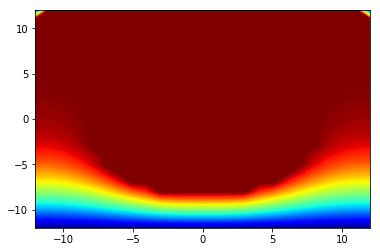

In [251]:
plt.contourf(Y,X[::-1],phi,200,cmap = plt.cm.jet)
Jx,Jy=compute_J(phi)

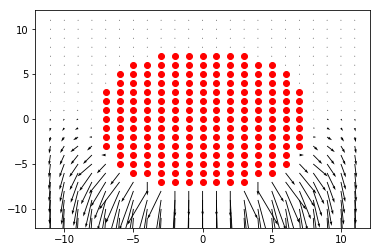

In [250]:
plt.quiver(Y[1:-1,1:-1],-X[1:-1,1:-1],-Jx[:,::-1],-Jy)
x_c,y_c=np.where(X**2+Y**2<8**2)
plt.plot(x_c-12,y_c-12,'ro')

# Results and Discussion

We have used finite differentiation to solve the laplace equation. Owing to the slow rate of reduction of the bounding error, this is a discouraged method. We have studied the contour plots and 3-D surface plots for the same.

Analysing the quiver plots for current densities affirms that: current is normal to the surface of the conductor, both the wire and the metal plate. 
